# Deploy Trained Models on Test Set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio 
import cv2
import os

from fastai.data.all import *
from fastai.vision.all import *

import av

from IPython.display import Video
from tqdm.notebook import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
data_path = Path('data/')
test_path = data_path/'test'
models_path = Path('models/')

## Converting the Videos to Frames

In [3]:
test_path.ls()

(#64) [Path('data/test/019d5b34_0'),Path('data/test/019d5b34_0.mp4'),Path('data/test/019d5b34_1'),Path('data/test/019d5b34_1.mp4'),Path('data/test/0b1495d3_0'),Path('data/test/0b1495d3_0.mp4'),Path('data/test/0b1495d3_1'),Path('data/test/0b1495d3_1.mp4'),Path('data/test/160606be_0'),Path('data/test/160606be_0.mp4')...]

In [4]:
names = []
for a in test_path.ls():
    names.append(a.stem)
for n in names:
    p_name = test_path/n
    if not p_name.exists(): p_name.mkdir()

frame_paths = []
for a in test_path.ls():
    if '.' not in str(a):
        frame_paths.append(a)
frame_paths[0:5]

[Path('data/test/019d5b34_0'),
 Path('data/test/019d5b34_1'),
 Path('data/test/0b1495d3_0'),
 Path('data/test/0b1495d3_1'),
 Path('data/test/160606be_0')]

In [5]:
def extract_frames(video_path):
    '''convert video to PIL images'''
    video = av.open(str(video_path), fps=25)
    for frame in video.decode(video=0):
        yield frame.to_image()

def avi2frames(video_path, path_frames=frame_paths, force=False):
    "Extract frames from avi file to jpgs"
    dest_path = video_path.parent/video_path.stem
    print(dest_path)
    video = av.open(str(video_path))
    for frame in video.decode(video=0):
        fname = dest_path/str('frame-%04d.png' % frame.index)
        if not os.path.exists(fname):
            frame.to_image().save(str(fname))

In [6]:
video_paths = []
for a in test_path.ls():
    if '.mp4' in str(a):
        video_paths.append(a)
v = video_paths[:3]
v

[Path('data/test/019d5b34_0.mp4'),
 Path('data/test/019d5b34_1.mp4'),
 Path('data/test/0b1495d3_0.mp4')]

In [7]:
#avi2frames(v[0])

In [8]:
#parallel(avi2frames, video_paths)

## Getting the Predictions

In [9]:
instances_path = frame_paths[0:3]
instances_path

[Path('data/test/019d5b34_0'),
 Path('data/test/019d5b34_1'),
 Path('data/test/0b1495d3_0')]

In [10]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    try:
        return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))
    except ValueError:
        return self.ls().sorted(key=lambda f: int(f.with_suffix('').name.split('-')[1]))

In [11]:
Path(instances_path[0]/'0').ls_sorted()

(#8) [Path('data/test/019d5b34_0/0/frame-0000.png'),Path('data/test/019d5b34_0/0/frame-0001.png'),Path('data/test/019d5b34_0/0/frame-0002.png'),Path('data/test/019d5b34_0/0/frame-0003.png'),Path('data/test/019d5b34_0/0/frame-0004.png'),Path('data/test/019d5b34_0/0/frame-0005.png'),Path('data/test/019d5b34_0/0/frame-0006.png'),Path('data/test/019d5b34_0/0/frame-0007.png')]

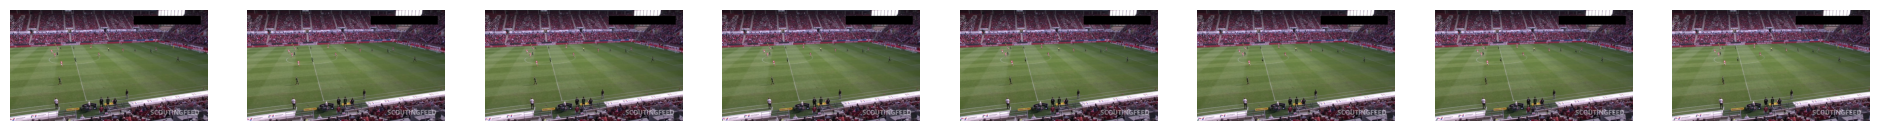

In [12]:
frames = Path(instances_path[0]/'0').ls_sorted()
show_images([Image.open(img) for img in frames])

In [13]:
def labeller(path):
    return '-' not in str(path)

In [14]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [15]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [16]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=8, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [labeller, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)

In [17]:
class RNNModel(Module):
    def __init__(self, arch=resnet34(), n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

In [18]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [19]:
throwin_learner = load_learner('throwin_v2_256.pkl', cpu=False)
#challenge_learner = load_learner('challenge_256.pkl', cpu=False)
#play_learner = load_learner('play_256.pkl', cpu=False)

In [21]:
# splitting up videos into 8 frame clips
for path in tqdm(frame_paths):
    count = 0
    tmp = path.ls_sorted()
    for p in tmp:
        if '.' in str(p):
            try:
                os.rename(p, path/f'{count}/{p.stem}.png')
            except FileNotFoundError:
                os.mkdir(path/f'{count}')
                os.rename(p, path/f'{count}/{p.stem}.png')
        try:
            if len(Path(path/f'{count}').ls()) == 8:
                count += 1
        except FileNotFoundError:
            print(p)
            break

  0%|          | 0/32 [00:00<?, ?it/s]

data\test\019d5b34_1\84


In [22]:
output = {}
for f in tqdm(frame_paths):
    for p in f.ls():
        output[p] = throwin_learner.predict(p)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
for k in output:
    if output[k][0] == 'True':
        print(k, output[k][1].numpy())